In [58]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import sys
sys.path.insert(0, '../drift_definition/')

In [60]:
import drift_definer

usage: ipykernel_launcher.py [-h] [-d DEPTH_DDEM]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-c08dd143-4fde-42b7-a68c-e8d4e6c1ab6a.json


SystemExit: 2

/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


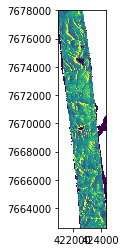

In [49]:
src = rasterio.open('../depth_dDEMs/hv/corrected/hv_depth_stack_mean.tif')
show(src, vmin=0,vmax=1)

In [50]:
arr = src.read(1)
print(np.nanmin(arr))
print(np.nanmax(arr))

-inf
20.114067


In [53]:
# We need to convert nonfinite values or weird no data, negative values
# to np.nan. These are mostly edges and by the lakes
arr[~np.isfinite(arr)] = np.nan
arr[arr < 0] = np.nan
# What is the reasonable upper bound of snow depth
# Probably 3 m for HV based on probes
arr[arr > 3] = np.nan
print(np.nanmin(arr))
print(np.nanmax(arr))

2.4419278e-06
2.999993


/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


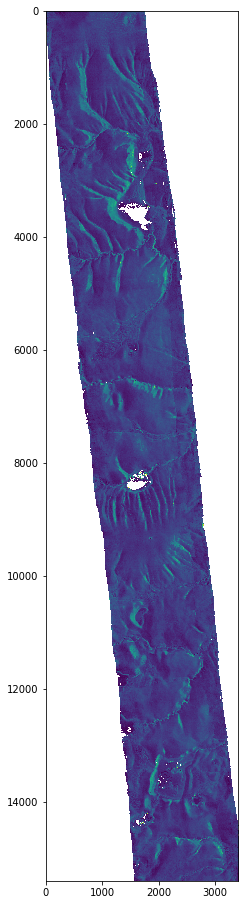

In [55]:
plt.figure(figsize=(10,16))
plt.imshow(arr, vmin=0, vmax=3)

In [65]:
def make_normalized_array(arr):
    normalized = (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    return normalized

In [66]:
narr = make_normalized_array(arr)
print(np.nanmax(narr), np.nanmin(narr))

1.0 0.0


In [67]:
np.nanmean(narr)

0.1835448

In [68]:
np.nanstd(narr)

0.080062635

In [70]:
depth = narr.copy()

In [71]:
# borrowing from drift definer
import pandas as pd

mean_depth = np.nanmean(depth) # median?
std_depth = np.nanstd(depth)
cv_depth = std_depth / mean_depth

# Thresholds to test (percentages of the mean depth)
# Obviously we expect the threshold to be above average depth
thresholds = np.round(np.arange(0.8, 2.1, 0.1) * mean_depth, 2)

# Computing total area / volume of all snow pixels
pxl_sz = src.meta['transform'][0]
total_area = (~np.isnan(depth)).sum() * pxl_sz
total_volume = np.nansum((~np.isnan(depth)) * depth * pxl_sz)

# Results stored in nested dict, keys are depth and results for that depth

d = dict()

for i in thresholds:

    k = str(i) + ' m'
    print('testing threshold of ' + k + '...')

    drift_mask = (depth >= i)
    depth_drift_masked = drift_mask * depth
    depth_drift_masked[depth_drift_masked == 0] = np.nan
    not_drift_mask = (depth < i)
    depth_not_drift_masked = not_drift_mask * depth
    depth_not_drift_masked[depth_not_drift_masked == 0] = np.nan

    d[k] = {}
    d[k]['drift_area'] = int(np.nansum(drift_mask))
    d[k]['not_drift_area'] = int(np.nansum(not_drift_mask))
    d[k]['drift_volume'] = int(np.nansum(drift_mask * depth * pxl_sz))
    d[k]['not_drift_volume'] = int(np.nansum(not_drift_mask * depth * pxl_sz))
    d[k]['mean_drift_depth'] = np.nanmean(depth_drift_masked)
    d[k]['mean_not_drift_depth'] = np.nanmean(depth_not_drift_masked)

# Move to dict to df for output and analysis
df = pd.DataFrame.from_dict(d).T
df['Drift Threshold (pct. of mean depth)'] = np.arange(0.8, 2.1, 0.1) * 100
df['Drift Area pct.'] = df.drift_area / total_area * 100
df['Not Drift Area pct.'] = df.not_drift_area / total_area * 100
df['Drift Volume pct.'] = df.drift_volume / total_volume * 100
df['Not Drift Volume pct.'] = df.not_drift_volume / total_volume * 100
df['Drift Volume-Area Difference (pct.)'] = df['Drift Volume pct.'] - df['Drift Area pct.']

df['Drift Volume-Area Difference Slope'] = np.gradient(df['Drift Volume-Area Difference (pct.)'])


# Find the inflection Threshold
df.set_index(df['Drift Threshold (pct. of mean depth)'], inplace=True)
inflection = df['Drift Volume-Area Difference Slope'].idxmin()
df['Inflection Threshold'] = inflection
df['Mean_Depth [m]'] = mean_depth
df['SD Depth [m]'] = std_depth
df['CV'] = cv_depth

print(inflection)


testing threshold of 0.15 m...
testing threshold of 0.17 m...
testing threshold of 0.18 m...
testing threshold of 0.2 m...
testing threshold of 0.22 m...
testing threshold of 0.24 m...
testing threshold of 0.26 m...
testing threshold of 0.28 m...
testing threshold of 0.29 m...
testing threshold of 0.31 m...
testing threshold of 0.33 m...
testing threshold of 0.35 m...
testing threshold of 0.37 m...
129.99999999999997


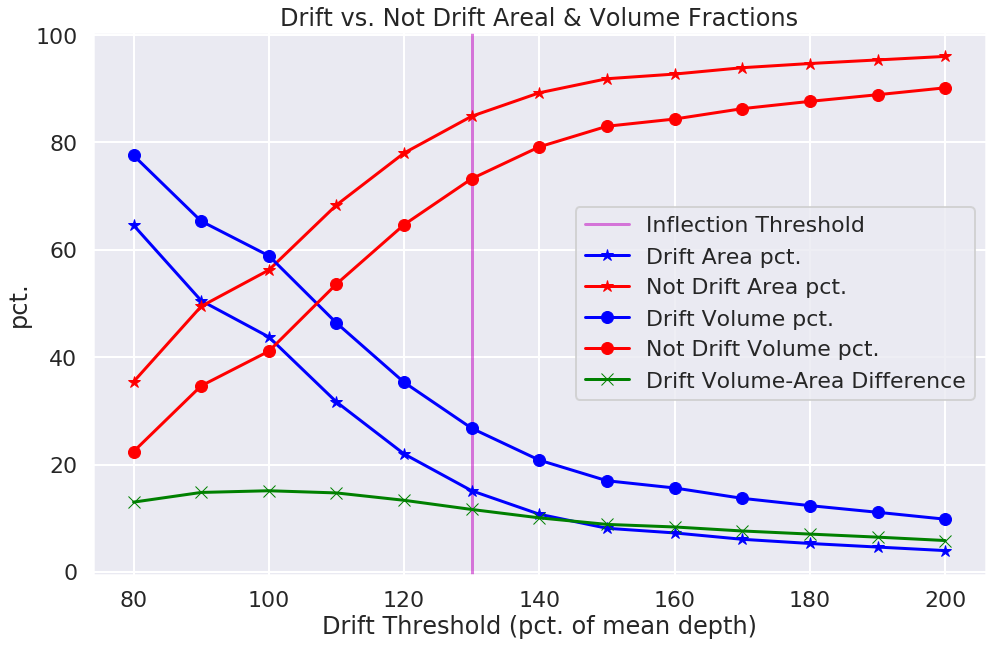

In [73]:
plt.figure(figsize=(16,10))
plt.title('Drift vs. Not Drift Areal & Volume Fractions')


plt.axvline(x=inflection, color='m', alpha=0.5, lw=3, label = 'Inflection Threshold')
plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Area pct.'], '-b*', label = 'Drift Area pct.')
plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Not Drift Area pct.'], '-r*', label = 'Not Drift Area pct.')
plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Volume pct.'], '-bo', label = 'Drift Volume pct.')
plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Not Drift Volume pct.'], '-ro', label = 'Not Drift Volume pct.')
plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Volume-Area Difference (pct.)'], '-gx', lw=3, label = 'Drift Volume-Area Difference')

plt.xlabel('Drift Threshold (pct. of mean depth)')
plt.ylabel('pct.')
plt.legend()

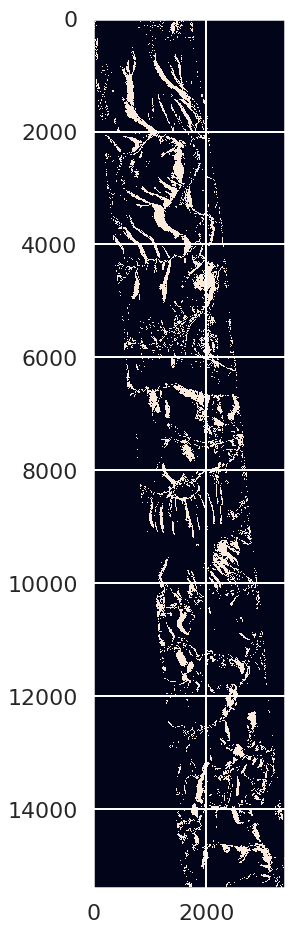

In [78]:
plt.figure(figsize=(10,16))
plt.imshow(narr>=(1.3*mean_depth))

In [79]:
dmask = narr>=(1.3 * mean_depth)

In [85]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 16), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [90]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk



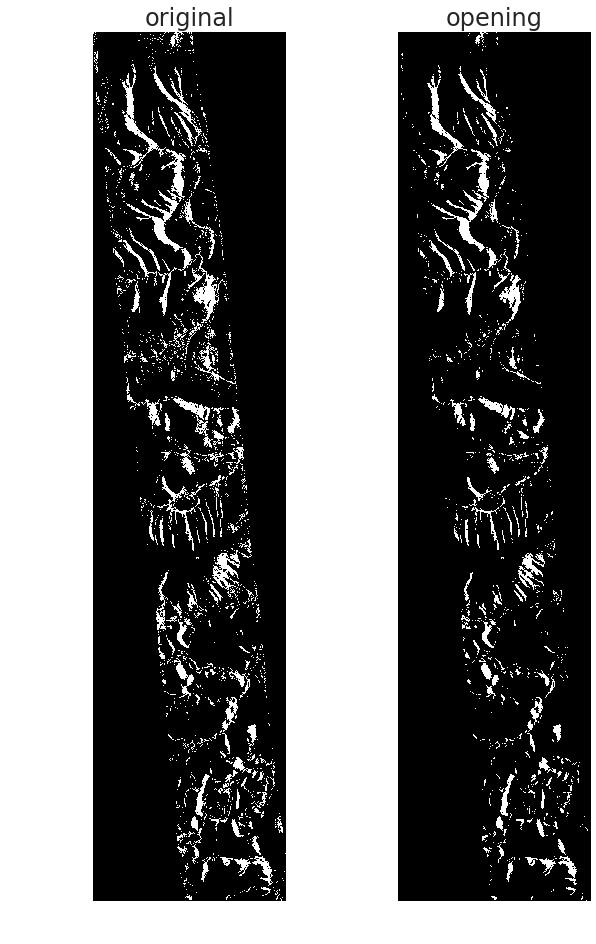

In [91]:
selem = disk(4)
opened = opening(dmask, selem)
plot_comparison(dmask, opened, 'opening')

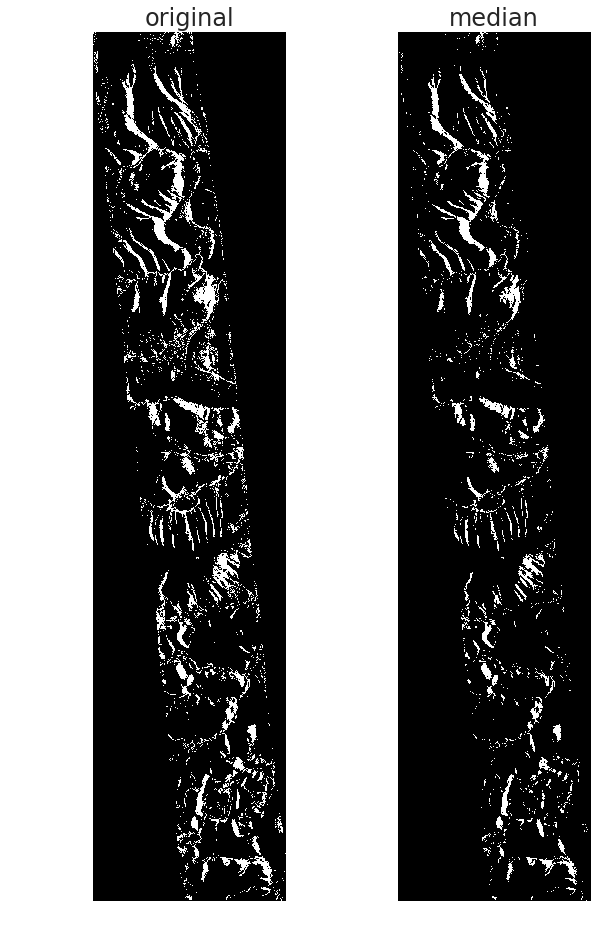

In [95]:
from skimage.filters.rank import median, minimum
selem = disk(2)
med = minimum(dmask, selem)
plot_comparison(dmask, med, 'median')


In [103]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches


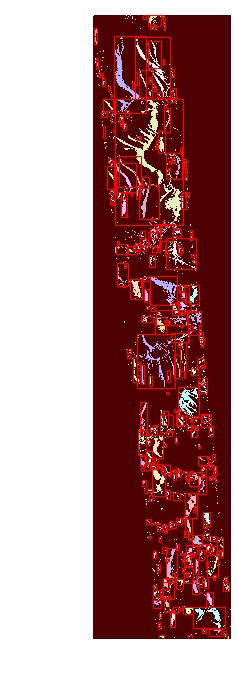

In [113]:
label_image = label(dmask, connectivity=2)

image_label_overlay = label2rgb(label_image, image=dmask)

fig, ax = plt.subplots(figsize=(6, 10))
ax.imshow(image_label_overlay)

drifts = []

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 1000:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        drifts.append(region)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [120]:
drifts[0].eccentricity

/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


0.9937490623154047

In [137]:
eccs = []
areas = []
perims = []
pas = []
mis = []
for d in drifts:
    eccs.append(d.eccentricity)
    areas.append(d.area)
    perims.append(d.perimeter)
    pas.append(d.perimeter / d.area)
    mis.append(d.mean_intensity, depth)


AttributeError: No intensity image specified.

(array([20., 39., 46., 47., 57., 39., 25., 17., 16.,  3.]),
 array([0.06573457, 0.12438607, 0.18303758, 0.24168908, 0.30034059,
        0.35899209, 0.41764359, 0.4762951 , 0.5349466 , 0.59359811,
        0.65224961]),
 <a list of 10 Patch objects>)

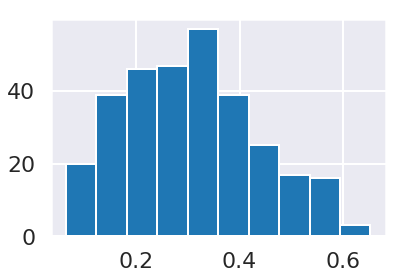

In [135]:
plt.hist(pas)

In [127]:
len(eccs)

309